In [2]:
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Median GTT 3728.8360420650097
66.68161434977578
Median GTT 3217.0172084130018
80.89686098654708
Median GTT 2820.0167304015295
82.6457399103139
Median GTT 1643.5707456978967
99.10313901345292
['-3,000', '0', '3,000', '6,000', '9,000', '12,000', '15,000+']


/scratch/local/jobs/33619305/ipykernel_1511371/3502332095.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels, fontsize=16)


<Figure size 640x480 with 0 Axes>

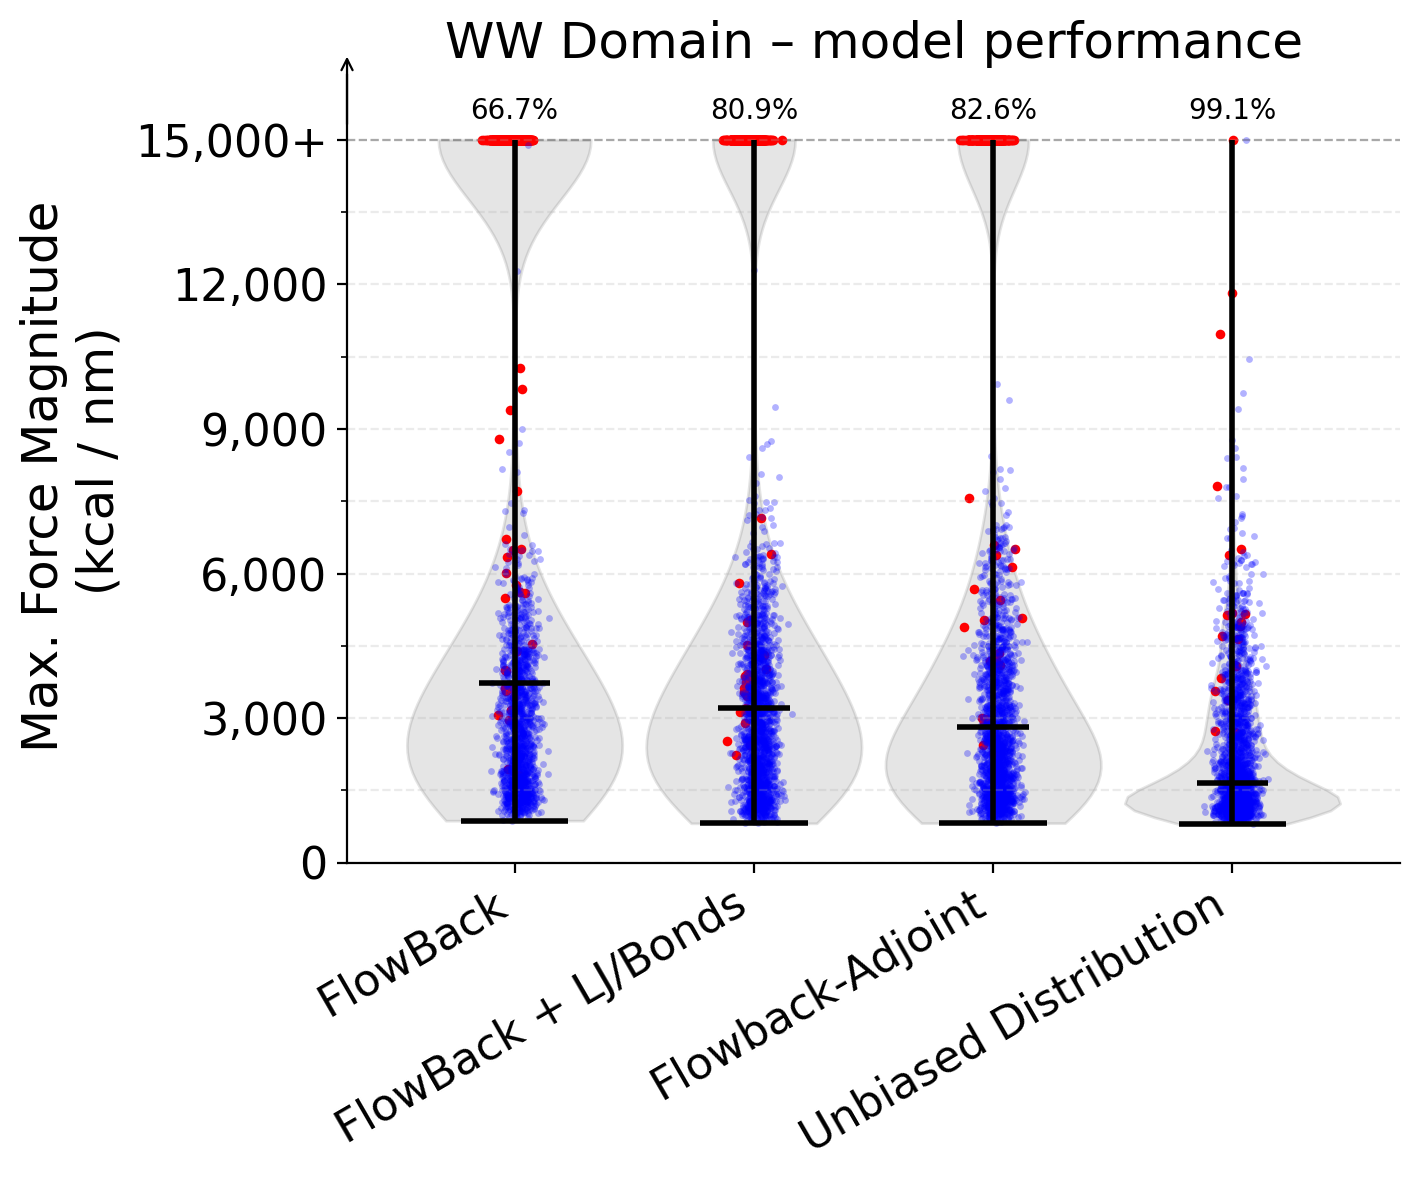

Median GTT 1556.9431166347993
87.80269058295964
Median GTT 1188.3962715105163
98.69955156950672
Median GTT 1159.2495219885277
99.64125560538116
Median GTT 1212.0219885277247
100.0
['-1,000', '0', '1,000', '2,000', '3,000', '4,000', '5,000', '6,000+']


/scratch/local/jobs/33619305/ipykernel_1511371/3502332095.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels, fontsize=16)


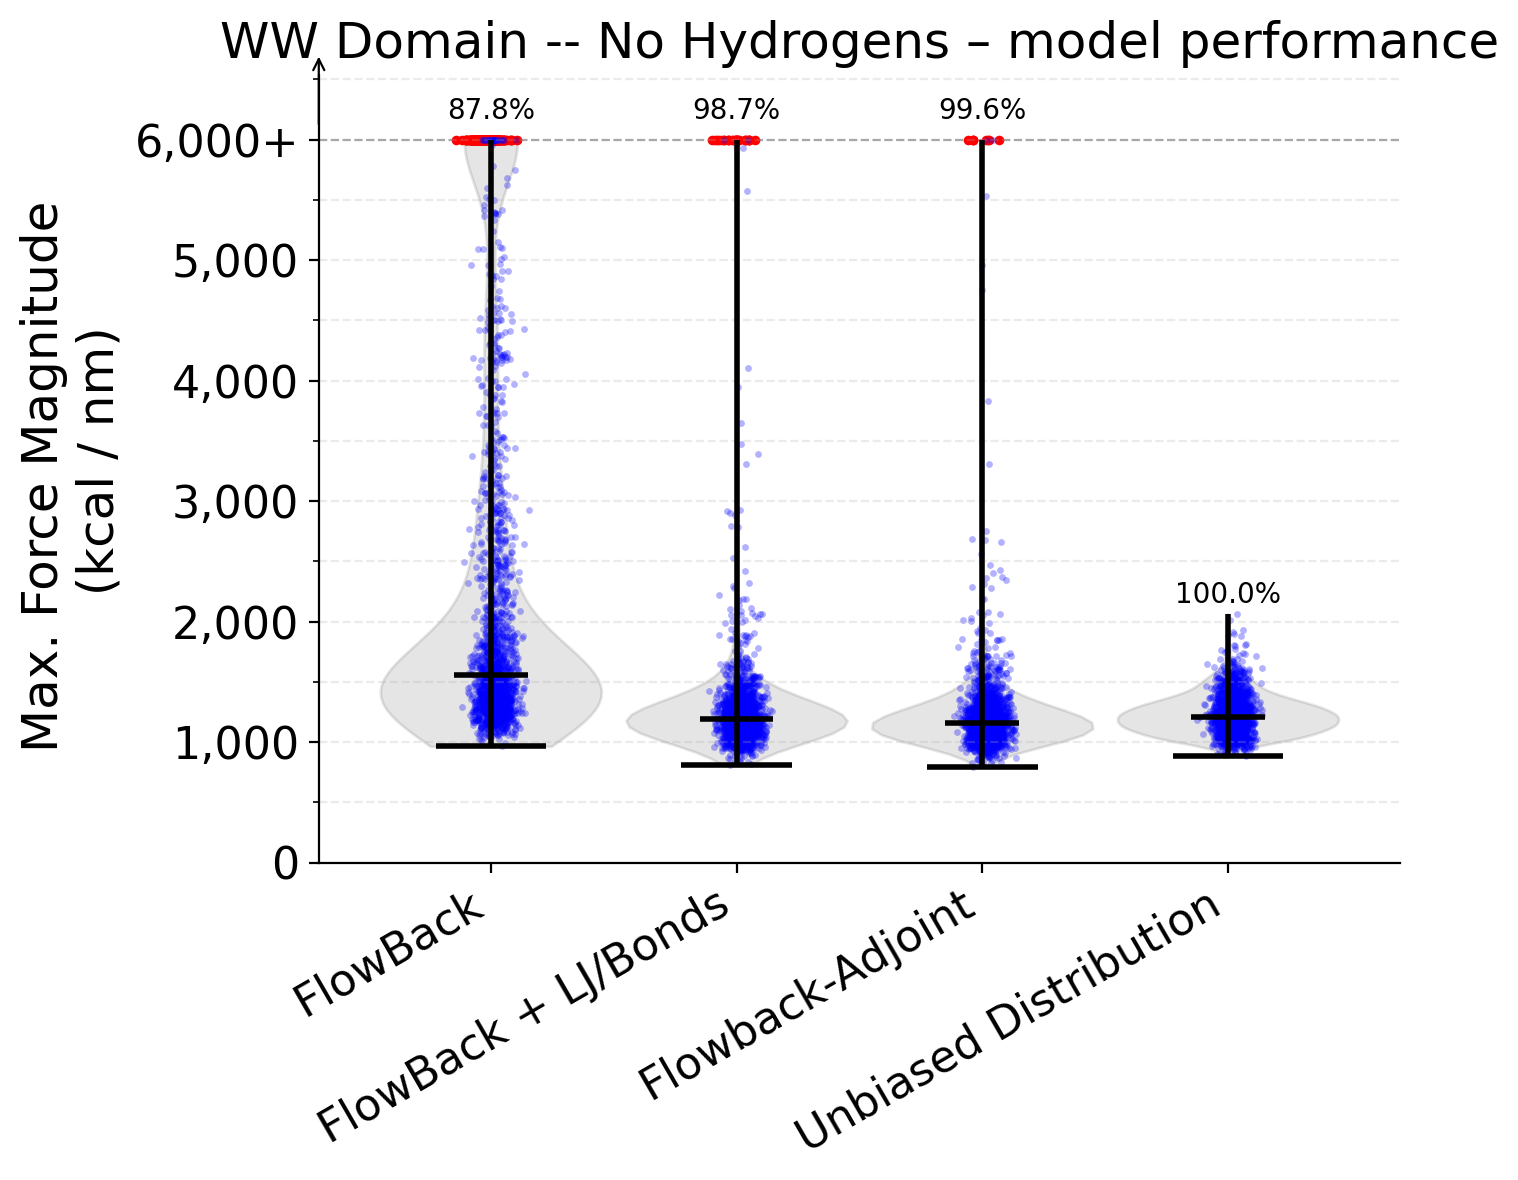

In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mticker

def percentage(protein, model, return_forces=True):
    data = pd.read_csv(f'stat_files/{protein}_{model}_stats.txt', sep='\t', header=None)
    return len(data[data[1] == True]) / len(data)
def control(protein):
    data = pd.read_csv(f'stat_files/{protein}_nomodel_stats.txt', sep='\t', header=None)
    return len(data[data[1] == True]) / len(data)

def plot_combined_violin_multi(
    protein: str,
    configs: list[dict],
    labels: list[str],
    colors: list[str],
    thresh: int       = 15_000,
    tick_step: int    = 3_000,
    jitter_scale:float = 0.04,
    name=None
):
    if len(configs) != len(labels) or len(labels) != len(colors):
        raise ValueError("configs, labels, and colors must have the same length")

    # colour palette for the scatter points (unchanged)
    swarm_palette = {
        "fail": {"swarm": "red"},
        "succ": {"swarm": "blue"},
    }

    fig, ax = plt.subplots(figsize=(1.6 + 1.4 * len(configs), 6), dpi=200)
    global_ymax = 0
    medians = []
    for pos, (cfg, col) in enumerate(zip(configs, colors)):
        model      = cfg.get("model")
        checkpoint = cfg.get("checkpoint")
        suffix     = cfg.get("suffix", "")

        # ── Load data ───────────────────────────────────────────────────
        if model is not None:
            fname = f"stat_files/{protein}_{model}_stats{suffix}.txt"
        else:
            fname = f"stat_files/{protein}_nomodel_stats{suffix}.txt"
        data = pd.read_csv(fname, sep="\t", header=None)
        data[2] /= 4.184
        # ── Pre-process ────────────────────────────────────────────────
        forces    = np.where(data[2] < thresh, data[2], thresh)
        fail_mask = data[1] == 0
        succ_mask = ~fail_mask
        success_rate = 100.0 * succ_mask.sum() / len(data)

        # ── Violin plot ────────────────────────────────────────────────
        parts = ax.violinplot(
            [forces],
            positions=[pos],
            widths=0.9,
            showmeans=False,
            showmedians=False,
        )

        # body / outline
        body = parts["bodies"][0]
        body.set_facecolor(col)
        body.set_edgecolor(col)
        body.set_alpha(0.1)

        # mean & median ticks (grey, centred)
        
        for y in (np.median(forces),):
            ax.hlines(y, pos - 0.15, pos + 0.15, lw=2, color=col)
            medians.append(y)
            print('Median', protein, y)
        # colour cmins and cbars, hide cmaxes
        for key in ("cmins", "cbars"):
            parts[key].set_color(col)
            parts[key].set_linewidth([2.0])
        parts["cmaxes"].set_visible(False)

        # ── Scatter points ────────────────────────────────────────────
        jitter = np.random.normal(scale=jitter_scale, size=len(data))
        if pos == 0:
            ax.scatter(
                pos + jitter[fail_mask] - 0.02,
                forces[fail_mask],
                s=12,
                alpha=1.0,
                color=swarm_palette["fail"]["swarm"],
                linewidths=0,
                label='Failures'
            )
            ax.scatter(
                pos + jitter[succ_mask] + 0.02,
                forces[succ_mask],
                s=6,
                alpha=0.30,
                color=swarm_palette["succ"]["swarm"],
                linewidths=0,
                label='Successes'
            )
        else:
            ax.scatter(
                pos + jitter[fail_mask] - 0.02,
                forces[fail_mask],
                s=12,
                alpha=1.0,
                color=swarm_palette["fail"]["swarm"],
                linewidths=0
            )
            ax.scatter(
                pos + jitter[succ_mask] + 0.02,
                forces[succ_mask],
                s=6,
                alpha=0.30,
                color=swarm_palette["succ"]["swarm"],
                linewidths=0
            )

        # success-rate annotation
        ax.text(
            pos,
            forces.max() * 1.02,
            f"{success_rate:.1f}%",
            ha="center",
            va="bottom",
            fontsize="medium",
        )
        print(success_rate)

        global_ymax = max(global_ymax, forces.max())

    # ── Global cosmetics ───────────────────────────────────────────────
    ax.axhline(thresh, ls="--", lw=0.8, color="grey", alpha=0.7, zorder=0)

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=30, fontsize=16, ha="right")
    ax.set_xlim(-0.7, len(labels) - 0.3)

    ax.set_ylabel("Max. Force Magnitude \n (kcal / nm)", fontsize=18)
    if name is not None:
        ax.set_title(f"{name} – model performance", fontsize=18)
    else:
        ax.set_title(f"{protein} – model performance", fontsize=18)
        

    ax.set_ylim(0, global_ymax * 1.09)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(tick_step))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(tick_step / 2))
    ax.grid(axis="y", which="both", linestyle="--", alpha=0.25)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # keep the ticks Matplotlib just chose …
    yticks = ax.get_yticks()
    
    # … but relabel the last one (the max) with a “+”
    new_labels = [f"{int(y):,}" for y in yticks[:-2]] + [f"{int(yticks[-2]):,}+"]
    print(new_labels)
    ax.set_yticklabels(new_labels, fontsize=16)
    ax.annotate(
    "",                                 # no text, just the arrow
    xy=(0, 1.03),                       # arrow head (x,y) in axes-fraction coords
    xytext=(0, 0.93),                   # tail a bit lower
    xycoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=0.8, color="k"),
    clip_on=False,                      # let it hang outside the axes
    )
    # ax.legend(frameon=False)
    # plt.plot(medians, color='gray', linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()
    
def plot_forces_violin(protein, model=None, checkpoint=None, thresh=1e5, tick_step=25_000):
    """
    Violin plot of maximum forces with a log-scale y-axis.
    A dashed line and annotation show how many runs exceed `thresh`.
    """
    # ── Load ──────────────────────────────────────────────────────────────────
    if model is not None and checkpoint is not None:
        fname = f"stat_files/{protein}_{model}_ckp-{checkpoint}_stats.txt"
    else:
        fname = f"stat_files/{protein}_nomodel_stats.txt"

    data = pd.read_csv(fname, sep="\t", header=None)

    # ── Group data ──────────────────────────────────────────────────────────
    forces  = data[2].to_numpy()
    forces  = np.where(forces > thresh, thresh, forces)
    labels  = ["MD Fail", "MD Success"]
    groups  = [forces[data[1] == 0], forces[data[1] == 1]]
    
    # Palette: dark edge / mid-light fill / pale swarm of same hue
    palette = {
        "fail": {"edge": "#b1400d", "fill": "#e76f51", "swarm": "#f4a582"},
        "succ": {"edge": "#1d5395", "fill": "#4a90e2", "swarm": "#8ab8ff"},
    }

    # ── Plot ────────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(6, 4))

    parts = ax.violinplot(
        groups,
        positions=[0, 1],
        showmeans=False,     # we’ll draw custom markers
        showmedians=False,
        widths=0.8,
    )
    # Customise each violin + add mean / median markers the same colour
    for idx, body in enumerate(parts["bodies"]):
        key   = "fail" if idx == 0 else "succ"
        col   = palette[key]
        body.set_facecolor(col["fill"])
        body.set_edgecolor(col["edge"])
        body.set_alpha(0.8)

        # mean + median (short horizontal ticks)
        stats_y = [np.median(groups[idx])]
        for y in stats_y:
            print('Median', protein, y)
            ax.hlines(
                y,
                idx - 0.25, idx + 0.25,          # narrow width
                lw=1.8,
                color=col["edge"],
            )

    # Swarm of individual points (small jitter, pale shade of same hue)
    jitter = np.random.normal(scale=0.04, size=len(data))
    labels = ['success', 'failure']
    for idx, key in enumerate(["fail", "succ"]):
        sel = data[1] == idx         # 0 = fail, 1 = success
        ax.scatter(
            data[1][sel] + jitter[sel],
            forces[sel],
            s=6,
            alpha=0.3,
            color=palette[key]["swarm"],
            linewidths=0,
            
        )
    edge_colours = [palette["fail"]["edge"], palette["succ"]["edge"]]

    for key in ("cbars", "cmaxes", "cmins"):
        parts[key].set_color(edge_colours)   # colours segments 0, 1, …
        parts[key].set_linewidth([2.0, 1.2]) # optional: one width per segment

    # ── Threshold line + counts ────────────────────────────────────────────
    # ax.axhline(thresh, ls="--", lw=0.8, color="grey", alpha=0.7)
    for xpos, grp, key in zip([0, 1], groups, ["fail", "succ"]):
        n_over = (grp > thresh).sum()
        if n_over:
            ax.text(
                xpos,
                thresh * 1.02,
                f"{n_over} > {thresh:,.0f}",
                ha="center",
                va="bottom",
                fontsize="small",
                color=palette[key]["edge"],
            )

    # Annotate sample sizes just above the highest point
    ymax = forces.max()
    for xpos, grp in zip([0, 1], groups):
        ax.text(
            xpos, thresh * 1.02,
            f"n = {len(grp)}",
            ha="center",
            va="bottom",
            fontsize="small",
        )

    # ── Axis / grid styling ────────────────────────────────────────────────
    ax.set_ylabel("Maximum Force Magnitude (kcal / nm)")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(labels)
    ax.set_title(f"{protein}: Distribution of Maximum Forces")

    # Tight major ticks every `tick_step`; faint minor ticks halfway
    ax.set_ylim(0, thresh * 1.95)
    # ax.yaxis.set_major_locator(mticker.MultipleLocator(tick_step))
    # ax.yaxis.set_minor_locator(mticker.MultipleLocator(tick_step / 2))
    # ax.grid(axis="y", which="both", linestyle="--", alpha=0.25)

    # Clean frame
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # keep the ticks Matplotlib just chose …
    yticks = ax.get_yticks()
    
    # … but relabel the last one (the max) with a “+”
    new_labels = [f"{int(y):,}" for y in yticks[:-1]] + [f"{int(yticks[-1]):,}+"]

    ax.set_yticklabels(new_labels, fontsize=16)
    
    plt.tight_layout()
    plt.show()

pct_fb = []
pct_ff = []
pct_adj = []
pct_control = []

proteins = ['PRB', 'GTT']
names = ['Protein B', 'WW Domain']
plt.figure(dpi=100)
for prot in proteins:
    try:
        pct_fb.append(percentage(prot, 'sc2', '250_euler'))
    except:
        pct_fb.append(0)
    try:
        pct_ff.append(percentage(prot, 'sc2', '250'))
    except:
        pct_ff.append(0)
    try:        
        pct_adj.append(percentage(prot, 'lr5_post', 2000))
    except:
        pct_adj.append(0)
    try:
        pct_control.append(control(prot))
    except:
        pct_control.append(0)
# plt.bar(np.arange(2) - 0.3, pct_fb, color='red', width=0.2, label='FlowBack')
# plt.bar(np.arange(2) - 0.1, pct_ff, color='blue', width=0.2, label='FlowBack + LJ/Bonds')
# plt.bar(np.arange(2) + 0.1, pct_adj, color='green', width=0.2, label='FlowBack Adjoint + LJ/Bonds')
# plt.bar(np.arange(2) + 0.3, pct_control, color='black', width=0.2, label='Unbiased Distribution')
# plt.title('Molecular Dynamics Test', fontsize=16)
# plt.xticks(np.arange(2), names)
# plt.yticks(fontsize=14)
# plt.legend(loc=4)
# plt.xlabel('Protein', fontsize=14)
# plt.ylabel('Success Rate', fontsize=14)
# print(pct_fb, pct_ff, pct_adj, pct_control)
# plt.show()
# plt.bar(0.1, percentage('alpha_synuclein', 'big_model', 15), width=0.2, color='blue', label='FlowBack + LJ/Bonds')
# plt.bar(-0.1, percentage('alpha_synuclein', 'big_model', '15_euler'),  width=0.2, color='red', label='OG Flowback')
# plt.bar(0.3, percentage('alpha_synuclein', 'lr5_post', 2000),  width=0.2, color='green', label='Flowback Adjoint')
# plt.bar(-0.3, control('hpack_synuclein'),  width=0.2, color='orange', label='BioEmu + HPack')
# plt.xticks(np.arange(4), ['$\\alpha$-synuclein', '', '', ''])
# plt.yticks(fontsize=14)
# plt.legend(loc=4)
# print(percentage('alpha_synuclein', 'big_model', '15_euler'))

# plot_forces_violin('GTT', 'big_model', 15)
# plot_combined_violin('GTT', 'big_model', 15)
# plot_combined_violin('GTT', 'big_model', "15_euler")
configs = [
    # big-model, ckp-15, Euler integration variant
    dict(model="big_model_ckp-15_euler_noise-0.003_chi_0.2", suffix=""),
    # big-model, ckp-15
    dict(model="big_model_ckp-15_noise-0.003_chi_0.25", suffix=""),
    # lr5, ckp-2000
    dict(model="n2503_post_ckp-7000_noise-0.003_chi_0.25", checkpoint=2000, suffix=""),
    # “nomodel” baseline (set model = None, checkpoint = None)
    dict(model=None, checkpoint=None, suffix=""),
    
]
configs2 = [
    dict(model="big_model_ckp-15_euler_noise-0.003_chi_0.2", checkpoint="15_euler", suffix="_noh"),
    dict(model="big_model_ckp-15_noise-0.003_chi_0.25", checkpoint=15, suffix="_noh"),
    dict(model="n2503_post_ckp-7000_noise-0.003_chi_0.25", checkpoint=2000, suffix="_noh"),
    dict(model=None, checkpoint=None, suffix="_noh")
]

labels = [
    "FlowBack",
    "FlowBack + LJ/Bonds",
    "Flowback-Adjoint",
    "Unbiased Distribution",
]
labels2 = [ 
    "FlowBack -- no hydrogens",
    "FlowBack + LJ/Bonds -- no hydrogens",
    "FlowBack-Adjoint -- no hydrogens",
    "Unbiased -- no hydrogens"
]
colors = ["black", "black", "black", "black"]
colors2 =  ["black", "black", "black", "black"]

plot_combined_violin_multi("GTT", configs, labels, colors, name='WW Domain')
plot_combined_violin_multi("GTT", configs2, labels, colors2, thresh=6000, tick_step=1000, name='WW Domain -- No Hydrogens')


Median PRB 5588.42017208413
50.80707148347425
Median PRB 3262.392447418738
63.797079169869335
Median PRB 3297.7891969407265
65.41122213681783
Median PRB 2000.6333652007647
99.53881629515757
['-3,000', '0', '3,000', '6,000', '9,000', '12,000', '15,000+']


/scratch/local/jobs/33619305/ipykernel_1511371/3502332095.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels, fontsize=16)


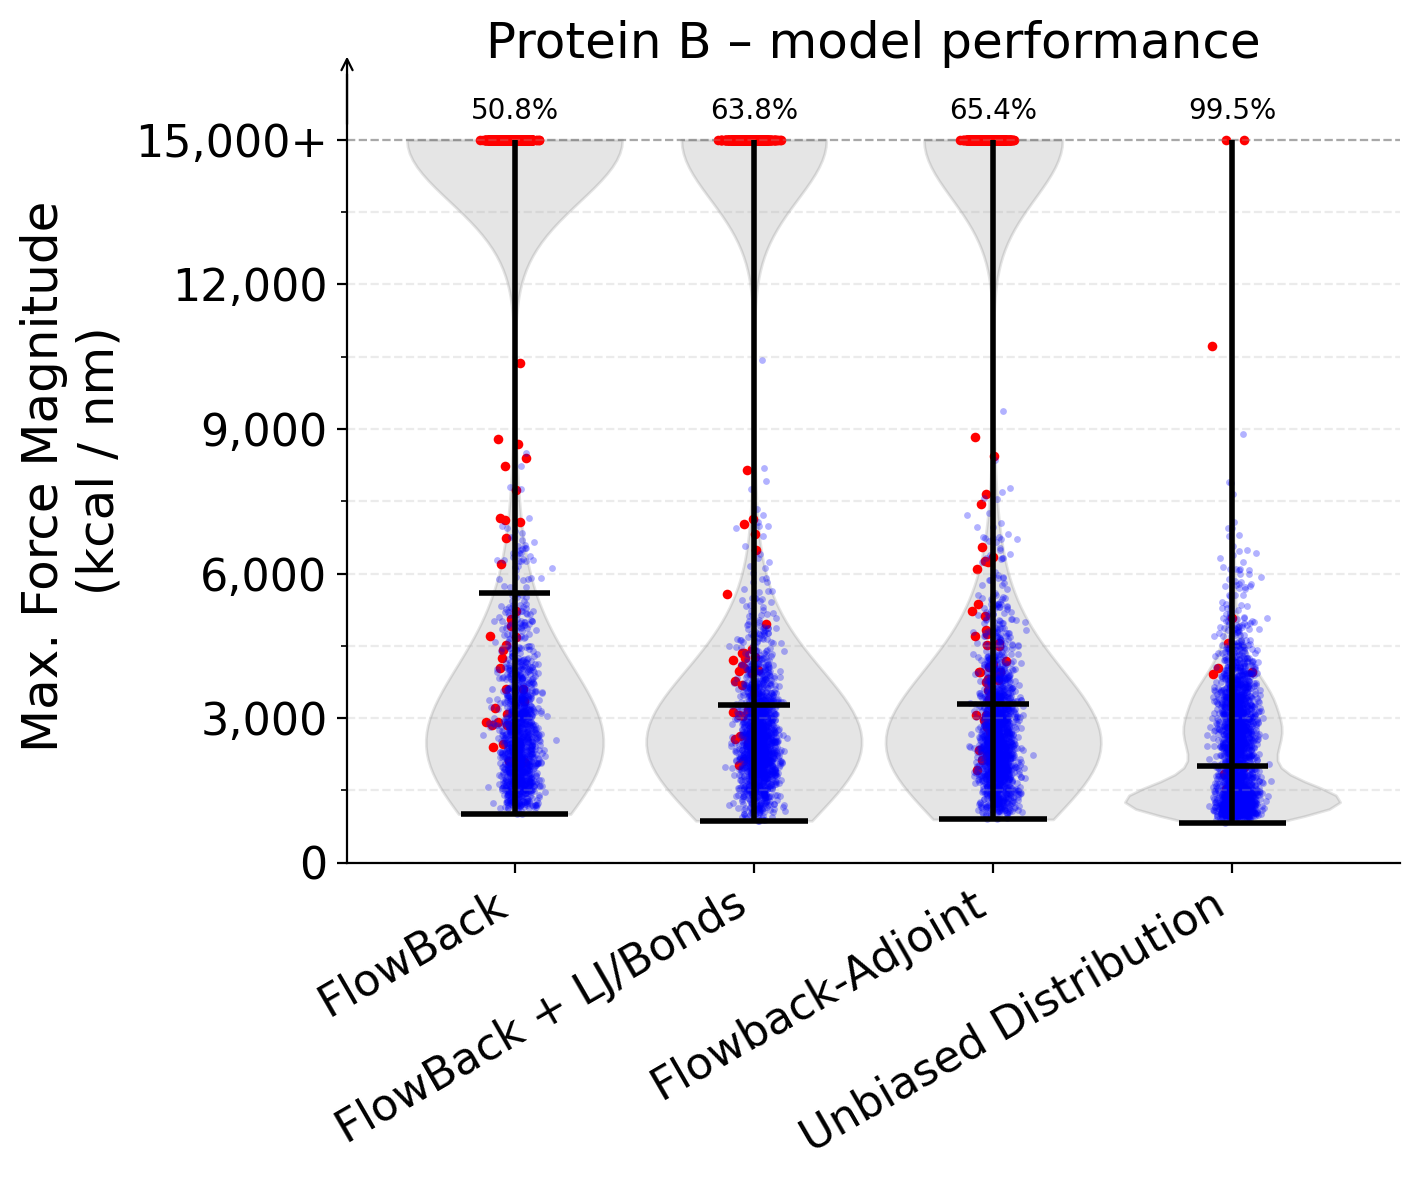

Median PRB 1945.8173996175908
84.12759415833973
Median PRB 1264.2327915869982
99.57724827056111
Median PRB 1214.029636711281
99.69254419677172
Median PRB 1271.6419694072658
100.0
['-1,000', '0', '1,000', '2,000', '3,000', '4,000', '5,000+']


/scratch/local/jobs/33619305/ipykernel_1511371/3502332095.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels, fontsize=16)


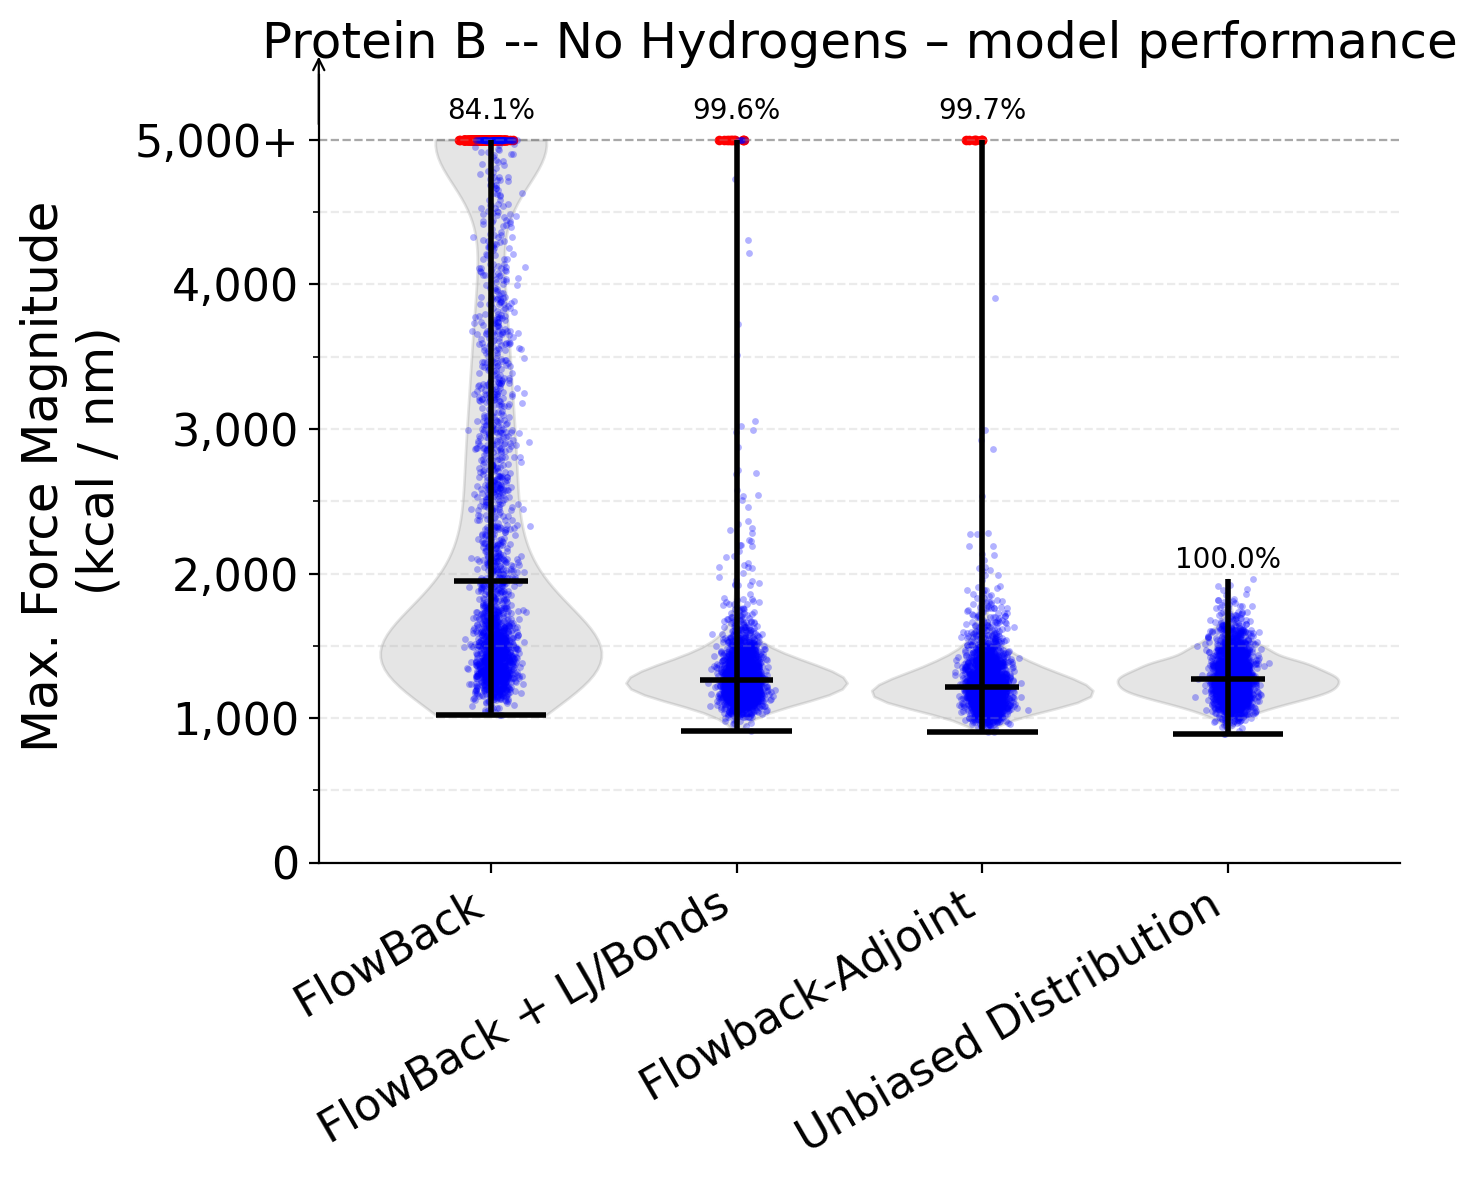

In [5]:
configs = [
    # big-model, ckp-15, Euler integration variant
    dict(model="big_model_ckp-15_euler_noise-0.003_chi_0.2", suffix=""),
    # big-model, ckp-15
    dict(model="big_model_ckp-15_noise-0.003_chi_0.25", suffix=""),
    # lr5, ckp-2000
    dict(model="n2503_post_ckp-7000_noise-0.003_chi_0.25", checkpoint=2000, suffix=""),
    # “nomodel” baseline (set model = None, checkpoint = None)
    dict(model=None, checkpoint=None, suffix=""),
    
]
configs2 = [
    dict(model="big_model_ckp-15_euler_noise-0.003_chi_0.2", checkpoint="15_euler", suffix="_noh"),
    dict(model="big_model_ckp-15_noise-0.003_chi_0.25", checkpoint=15, suffix="_noh"),
    dict(model="n2503_post_ckp-7000_noise-0.003_chi_0.25", checkpoint=2000, suffix="_noh"),
    dict(model=None, checkpoint=None, suffix="_noh")
]

labels3 = [ 
    "FlowBack",
    "FlowBack + LJ/Bonds",
    "Flowback-Adjoint",
    "Unbiased Distribution"
]
colors3= ["black", "black", "black", "black"]

plot_combined_violin_multi("PRB", configs, labels3, colors3, name='Protein B')
plot_combined_violin_multi("PRB", configs2, labels3, colors3, thresh=5000, tick_step=1000, name='Protein B -- No Hydrogens')


In [ ]:
## pdb = md.load('outputs/GTT/post_train_charmm_ckp-2_noise-0.003/frame_0_1.pdb')
pdb.center_coordinates()
view = nv.show_mdtraj(pdb[::-1])
view.clear()
view.add_ball_and_stick()
view

In [4]:
import time
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import mdtraj as md
import torch
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit import RDLogger
from rdkit import rdBase
from openmm import *
import os
from openmm.app import *
from openmm.unit import *
import argparse 
import tempfile
import MDAnalysis as mda
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess
import warnings
import psutil
import gc
import io
import time
from energy_utils import *
%load_ext autoreload
%autoreload 2
# model = 'sc2'
# checkpoint = 250
# frame = 15
def _clone_nb_settings(src, dest):
    dest.setReactionFieldDielectric(src.getReactionFieldDielectric())
    dest.setEwaldErrorTolerance(src.getEwaldErrorTolerance())
    dest.setUseDispersionCorrection(src.getUseDispersionCorrection())
    dest.setUseSwitchingFunction(src.getUseSwitchingFunction())
    dest.setSwitchingDistance(src.getSwitchingDistance())

def _map_original_to_processed_indices(original_pdb, processed_pdb):
    """
    Create a mapping from original PDB atom indices to processed PDB indices after pdb2gmx.
    
    Parameters:
    -----------
    original_pdb : str
        Path to the original PDB file
    processed_pdb : str
        Path to the processed PDB file (after pdb2gmx)
        
    Returns:
    --------
    list
        List where index position is the original atom index and value is the new index.
        -1 indicates no match was found for that original atom.
    """
    # Load both structures
    orig_u = mda.Universe(original_pdb)
    proc_u = mda.Universe(processed_pdb)
    
    # Initialize mapping list with -1 (indicating no match)
    n_orig_atoms = len(orig_u.atoms)
    index_map = -1 * np.ones(n_orig_atoms).astype(int)
    
    # Create unique identifiers for each atom in processed structure
    proc_dict = {}
    for atom in proc_u.atoms:
        identifier = (atom.resnum, atom.resname, atom.name)
        proc_dict[identifier] = atom.ix
    
    # Map original atoms to processed atoms
    for atom in orig_u.atoms:
        identifier = (atom.resnum, atom.resname, atom.name)
        if identifier in proc_dict:
            index_map[atom.ix] = proc_dict[identifier]
        elif atom.name == 'O':
            identifier = (atom.resnum, atom.resname, 'OT1')
            index_map[atom.ix] = proc_dict[identifier]
        elif atom.resname == 'ILE' and atom.name == 'CD1':
            identifier = (atom.resnum, atom.resname, 'CD')
            index_map[atom.ix] = proc_dict[identifier]
    return index_map


# def time_elapsed(func):
#     def wrapper(*args, **kwargs):
#         start = time.time()
#         result = func(*args, **kwargs)
#         elapsed = time.time() - start
#         print(f"Time elapsed: {elapsed:.6f} seconds")
#         return result
#     return wrapper

# @time_elapsed
def silence_atoms_and_shift_charge(nbforce, topology, mute, context=None):
    """
    Zero LJ and charge on each atom in *mute* and transfer that charge
    to its first bonded neighbour that is **not** in *mute*.

    Parameters
    ----------
    nbforce : openmm.NonbondedForce
        The force we are modifying.
    topology : openmm.app.Topology
        Needed to discover bonding so we know where to move the charge.
    mute : iterable of int
        Particle indices to silence.
    context : openmm.Context, optional
        Pass the existing Context if you already created one so we can
        push the new parameters with `updateParametersInContext`.
    """
    mute    = set(int(i) for i in mute)
    shifts  = defaultdict(lambda: 0.0*elementary_charge)   # charge → heavy atom
    nbforce.setUseDispersionCorrection(False)
    # print(nbforce.getNonbondedMethod())
    # nbforce.setNonbondedMethod(NonbondedForce.CutoffPeriodic)
    # ------------------------------------------------------------------
    # 1. build a quick neighbour map from the Topology
    # ------------------------------------------------------------------
    neighbours = defaultdict(list)
    for bond in topology.bonds:
        i, j = bond[0].index, bond[1].index
        neighbours[i].append(j)
        neighbours[j].append(i)

    # ------------------------------------------------------------------
    # 2. zero LJ & charge on the muted atoms, remember the charge removed
    # ------------------------------------------------------------------
    for idx in mute:
        q, sigma, eps = nbforce.getParticleParameters(idx)

        # accumulate the charge so we can add it to the parent later
        if abs(q.value_in_unit(elementary_charge)) > 1e-12:
            # first bonded neighbour that is NOT muted
            try:
                parent = next(n for n in neighbours[idx] if n not in mute)
                # print(topology.atom(parent), q)
                shifts[parent] += q
            except StopIteration:
                warnings.warn(f"Atom {idx} is muted but has no non-muted neighbours;"
                              " total charge will not be conserved!")

        # zero LJ *and* charge
        nbforce.setParticleParameters(idx,
                                      0.0*elementary_charge,
                                      sigma,
                                      0.0*kilojoule_per_mole)

    # ------------------------------------------------------------------
    # 3. apply the accumulated charge shifts to the parent atoms
    # ------------------------------------------------------------------
    for idx, dq in shifts.items():
        q, sigma, eps = nbforce.getParticleParameters(idx)
        nbforce.setParticleParameters(idx, q + dq, sigma, eps)

    # ------------------------------------------------------------------
    # 4. update every exception so chargeProd matches the new charges
    # ------------------------------------------------------------------
    for k in range(nbforce.getNumExceptions()):
        i, j, qprod, sigma, eps = nbforce.getExceptionParameters(k)
        
        qi = nbforce.getParticleParameters(i)[0]
        qj = nbforce.getParticleParameters(j)[0]
        # print(topology.atom(i), topology.atom(j), sigma, eps)
        if topology.atom(i).element.name == 'hydrogen' or topology.atom(j).element.name =='hydrogen':
            nbforce.setExceptionParameters(k, i, j, qi*qj, sigma, 0.0*kilojoule_per_mole)
        else:
            nbforce.setExceptionParameters(k, i, j, qi*qj, sigma, eps)
    
    
def energy(model, checkpoint, frame, cur_pdb=None):
    with tempfile.TemporaryDirectory(dir='/project2/andrewferguson/berlaga') as temp_dir:
        if cur_pdb is None:
            pdb_file = f'outputs/GTT_test/{model}_ckp-{checkpoint}_noise-0.003/frame_{frame}_1.pdb'
        else:
            pdb_file = cur_pdb
        t = md.load(pdb_file)
        structure_file = f"{temp_dir}/structure.gro"
        topology_file = f"{temp_dir}/topol.top"
    
        commands = [
           "gmx_mpi", "pdb2gmx", "-f", pdb_file, "-o", structure_file, "-p", topology_file,
            "-ff", "charmm27", "-water", "spce", "-ter", "-nobackup", "-quiet", "-i", f"{temp_dir}/posre"
        ]
        # process = subprocess.Popen(commands, stdin=subprocess.PIPE, text=True)
        process = subprocess.Popen(commands, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, bufsize=1024 * 1024 * 8, text=True)
        
        stdout, stderr = process.communicate('0\n0\n')
        index_map = _map_original_to_processed_indices(pdb_file, structure_file)
        gro = GromacsGroFile(structure_file)
        original_box = gro.getPeriodicBoxVectors()
        expanded_box = (
            original_box[0] + Vec3(2, 0, 0) * nanometer,
            original_box[1] + Vec3(0, 2, 0) * nanometer,
            original_box[2] + Vec3(0, 0, 2) * nanometer,
        )

        topology = GromacsTopFile(topology_file, periodicBoxVectors=expanded_box, includeDir=temp_dir)
        # Create simulation system
        system = topology.createSystem(nonbondedMethod=CutoffPeriodic, nonbondedCutoff=1.0*nanometer,constraints=None)
    
        t2 = md.load(structure_file)
        selected_atoms = index_map
        new_bond_force = HarmonicBondForce()
        new_bond_force.setForceGroup(10)
        new_angle_force = HarmonicAngleForce()
        new_angle_force.setForceGroup(11)
        new_torsion_force = PeriodicTorsionForce()
        new_torsion_force.setForceGroup(12)
        new_custom_torsion_force = CustomTorsionForce("0.5*k*(thetap-theta0)^2; thetap = step(-(theta-theta0+pi))*2*pi+theta+step(theta-theta0-pi)*(-2*pi); pi = 3.14159265358979")
        new_custom_torsion_force.addPerTorsionParameter('theta0')
        new_custom_torsion_force.addPerTorsionParameter('k')
        new_custom_torsion_force.setForceGroup(13)
        
        for force in enumerate(system.getForces()):
            force_ = force[1]
            if isinstance(force_, HarmonicBondForce):
                for i in range(force_.getNumBonds()):
                    p1, p2, length, k = force_.getBondParameters(i)
                    if p1 in selected_atoms and p2 in selected_atoms:
                        new_bond_force.addBond(p1, p2, length, k)
        
            elif isinstance(force_, HarmonicAngleForce):
                for i in range(force_.getNumAngles()):
                    p1, p2, p3, angle, k = force_.getAngleParameters(i)
                    if p1 in selected_atoms and p2 in selected_atoms and p3 in selected_atoms:
                        new_angle_force.addAngle(p1, p2, p3, angle, k)
        
            elif isinstance(force_, PeriodicTorsionForce):
                for i in range(force_.getNumTorsions()):
                    p1, p2, p3, p4, periodicity, phase, k = force_.getTorsionParameters(i)
                    if p1 in selected_atoms and p2 in selected_atoms and p3 in selected_atoms and p4 in selected_atoms:
                        new_torsion_force.addTorsion(p1, p2, p3, p4, periodicity, phase, k)
    
            
            elif isinstance(force_, CustomTorsionForce):
                for i in range(force_.getNumTorsions()):
                    p1, p2, p3, p4, params = force_.getTorsionParameters(i)
                    if p1 in selected_atoms and p2 in selected_atoms and p3 in selected_atoms and p4 in selected_atoms:
                        new_custom_torsion_force.addTorsion(p1, p2, p3, p4, params)
            # elif isinstance(force_, NonbondedForce) and not isinstance(force_, CMMotionRemover):
            #     new_nb_force = prune_nonbonded(force_, index_map)
            #     new_nb_force.setForceGroup(15)
        # print_memory_usage()
        # Remove old forces and add the new ones
        for fi in range(len(system.getForces()) - 1, -1, -1):
            force_ = system.getForce(fi)
            if isinstance(force_, CMMotionRemover):
                system.removeForce(fi)
            elif isinstance(force_, CMAPTorsionForce):
                force_.setForceGroup(14)
                continue
            elif isinstance(force_, NonbondedForce) and not isinstance(force_, CMMotionRemover):
                mute_atoms = np.setdiff1d(np.arange(force_.getNumParticles()), selected_atoms)
                # print(t.top.n_atoms, t2.top.n_atoms)
                silence_atoms_and_shift_charge(force_, t2.top, mute_atoms)
                force_.setForceGroup(15)
                
                # continue
            else:
                system.removeForce(fi)  # Remove each old force
        
        system.addForce(new_bond_force)
        system.addForce(new_angle_force)
        system.addForce(new_torsion_force)
        system.addForce(new_custom_torsion_force)
        # system.addForce(new_nb_force)
    
        
        # Set integrator
        integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
        context = Context(system, integrator)
        context.setPositions(gro.positions)
        
        state = context.getState(getEnergy=True, getForces=True)
    
        
        en = state.getPotentialEnergy()
        forces = state.getForces(asNumpy=True)
        
        force_mags = np.linalg.norm(forces, axis=1)
        # plt.plot(np.log(force_mags[index_map]))
        # plt.ylim(0, 100)
        # plt.show()
        # print([(t2.top.atom(i), force_mags[i]) for i in (np.argpartition(force_mags, -5)[-5:])])
        # for j in range(10, 16):
        #     state = context.getState(getEnergy=True, getForces=True, groups={j})
            
        #     #forces = state.getForces(asNumpy=True)[index_map] 

                        
        #     # force_mags = np.linalg.norm(forces, axis=1)
        #     print(j, state.getPotentialEnergy())
            
            
            #     plt.plot(force_mags)
        return en.value_in_unit(kilojoule_per_mole)
        


In [3]:
# fb = []
# fba = []
# en = []
# from tqdm import tqdm
# for frame in tqdm(range(50)):
#     fb.append(energy('sc2', 250, frame))
#     fba.append(energy('acc_grad_16_post', 1, frame))
#     en.append(energy('sc2', 250, 0, cur_pdb=f'data/GTT_clean_AA/frame_{frame}.pdb'))

# plt.plot(fb)
# plt.plot(fba)
# plt.plot(en)
%load_ext autoreload
%autoreload 2
protein = 'PRB'
f = 1
# print(energy(0, 0, 0,  f'outputs/{protein}/big_model_ckp-15_euler_noise-0.003/frame_{f}_1.pdb'))
print(np.mean([energy(0, 0, 0,  f'outputs/{protein}_test/big_model_ckp-15_noise-0.003/frame_{f}_{k}.pdb') for k in range(1, 10)]))
# print(energy('test1', 0, 0,  f'outputs/{protein}/big_mlr5_post_ckp-0_noise-0.003/frame_{f}_1.pdb'))
# for i in range(1):
print(np.mean([energy('test1', 0, 0,  f'outputs/{protein}_test/lr5_post_ckp-100_noise-0.003/frame_{f}_{k}.pdb') for k in range(1, 10)]))
print(np.mean([energy('test1', 0, 0,  f'outputs/{protein}_test/lr5_post_ckp-200_noise-0.003/frame_{f}_{k}.pdb') for k in range(1, 10)]))
print(np.mean([energy('test1', 0, 0,  f'outputs/{protein}_test/lr5_post_ckp-300_noise-0.003/frame_{f}_{k}.pdb') for k in range(1, 10)]))

# print(energy('test1', 0, 0,  f'outputs/{protein}_test/loo_post_ckp-300_noise-0.003/frame_{f}_1.pdb'))

# print(energy('test1', 0, 0,  f'outputs/{protein}/adjoint_post_ckp-6000_euler_noise-0.003/frame_{f}_1.pdb'))
# print(energy('acc_grad_16_post', 1, f))
energy('test2', 0, 0, f'data/{protein}_clean_AA/frame_{f}.pdb' )


NameError: name 'energy' is not defined

In [ ]:
print(energy(0, 0, 0,  f'outputs/GTT_test/big_model_ckp-15_noise-0.003/frame_0_1.pdb'))
print(energy(0, 0, 0,  f'outputs/one_GTT/big_model_ckp-15/frame_0_1.pdb'))
print(energy(0, 0, 0,  f'outputs/one_GTT/big_model_ckp-15/frame_0_2.pdb'))
print(energy(0, 0, 0,  f'outputs/one_GTT/n010_post_ckp-2000/frame_0_1.pdb'))
print(energy(0, 0, 0,  f'outputs/one_GTT/n010_post_ckp-2000/frame_0_2.pdb'))

In [5]:
import nglview as nv
import mdtraj as md

In [86]:
%load_ext autoreload
%autoreload 2
protein = 'GTT'
topology_file = "/project/andrewferguson/DESRES/DESRES-Trajectory_CLN025-0-protein/system_reorder.pdb"
from utils import clash_res_percent
frame = 11

traj = md.load(f'data/{protein}_clean_AA/frame_{frame}.pdb')
traj.center_coordinates()
# traj.superpose(traj[0])

# print([a for a in traj_sidechain.top.atoms])


# traj3 = traj.atom_slice(traj.top.select('resname TRP'))

# traj = md.load('test1_h.pdb')
# traj2 = md.load('test2_h.pdb')
# phe30_ha = traj.atom_slice(traj.top.select('resSeq 30 and name HA or name OXT or (resSeq 29 and name C)'))

view = nv.show_mdtraj(traj)
view.clear()
a = view.add_trajectory(traj)
a.clear_representations()
a.add_representation('ball+stick', opacity=0.3, color='green')

for i in range(100):
    traj2 = md.load(f'outputs/two_{protein}/f03_post_ckp-700_noise-0.003_chi-0.6/frame_{frame}_{i+1}.pdb')
    print(clash_res_percent(traj2[-1]))
    traj2.superpose(traj)
    # traj2.superpose(traj, atom_indices=np.arange(traj2.top.n_atoms), ref_atom_indices=traj.top.select('not element H and not name OXT'))
    # traj2 = traj2.atom_slice(traj2.top.select('resname TRP'))
    
    print(np.sum(get_all_chiralities_vec(traj2) == 1))
    a = view.add_trajectory(traj2[::-1])
    a.clear_representations()
    a.add_representation('ball+stick')

# for i in range(2):
#     traj3 = md.load(f'outputs/{protein}_test/n010_post_ckp-4000/frame_{frame}_{i+1}.pdb')
#     traj3.superpose(traj)
#     # traj3 = traj3.atom_slice(traj3.top.select('resid 30 to 35'))
#     a = view.add_trajectory(traj3)
#     a.clear_representations()
#     a.add_representation('ball+stick', color='purple', opacity=0.2)
#     # a.add_representation('ball+stick')

# view

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
5.714285714285714
0
0.0
0


/scratch/midway3/berlaga/miniconda3/envs/djax/lib/python3.11/site-packages/mdtraj/geometry/contact.py:199: UserWarning: selected topology includes at least one glycine residue, which has no heavy atoms in its sidechain. The distances involving glycine residues will be computed using the sidechain hydrogen instead.
  warnings.warn('selected topology includes at least one glycine residue, which has no heavy atoms in its sidechain. The distances involving glycine residues '


5.714285714285714
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
5.714285714285714
0
0.0
1
0.0
0
0.0
0
0.0
0
0.0
0
0.0
2
5.714285714285714
0
0.0
1
0.0
0
0.0
1
0.0
0
0.0
0
0.0
1
5.714285714285714
0
0.0
1
0.0
0
5.714285714285714
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
1
0.0
0
0.0
0
5.714285714285714
0
0.0
0
0.0
0
0.0
0
5.714285714285714
1
8.571428571428571
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
1
0.0
0
0.0
0
0.0
0
0.0
0
0.0
1
0.0
0
0.0
1
0.0
0
0.0
1
0.0
0
0.0
0
0.0
0
0.0
0
0.0
0
0.0
1
0.0
0
0.0
0
0.0
0
0.0
0
5.714285714285714
0
0.0
0
0.0
0
0.0
0
5.714285714285714
0
0.0
1
0.0
0
0.0
0
0.0
0
0.0
0
5.714285714285714
0
0.0
0
0.0
0
0.0
0
0.0
1
0.0
0
0.0
1
0.0
0
0.0
0
0.0
0
0.0
0


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
# plt.hist( 20)
n_bins = 40
all_hist_1 = np.zeros(n_bins)
all_hist_2 = np.zeros(n_bins)
all_hist_3 = np.zeros(n_bins)
protein = 'PRB'
for i in tqdm(range(50)):
    traj = md.load(f'outputs/{protein}/test_oom_post_ckp-14500_noise-0.003/frame_{40 * i}_1.pdb')
    traj2 = md.load(f'data/{protein}_clean_AA/frame_{40 * i}.pdb')
    traj3 = md.load(f'outputs/{protein}/big_model_ckp-15_noise-0.003/frame_{40 * i}_1.pdb')
    hist, bins = np.histogram(md.compute_chi1(traj)[1], np.linspace(-np.pi, np.pi, n_bins+1))
    hist2, bins2 = np.histogram(md.compute_chi1(traj2)[1], np.linspace(-np.pi, np.pi, n_bins+1))
    hist3, bins3 = np.histogram(md.compute_chi1(traj3)[1], np.linspace(-np.pi, np.pi, n_bins+1))
    all_hist_1 += hist
    all_hist_2 += hist2
    all_hist_3 += hist3

bins = (bins[1:] + bins[:1]) / 2
all_hist_1 /= np.sum(all_hist_1)
all_hist_2 /= np.sum(all_hist_2)
all_hist_3 /= np.sum(all_hist_3)
plt.plot(bins, all_hist_3, label='FB')
plt.plot(bins, all_hist_1, label='AM')
plt.plot(bins, all_hist_2, label='True')
plt.legend()
plt.xlabel('$\chi_1$')

In [ ]:
traj = md.load('outputs/GTT_test/test2_post_ckp-0_noise-0.003/frame_1_dt.pdb')
ref = md.load('data/GTT/frame_1.pdb')
arg32 = traj.atom_slice(traj.top.select('resid 31'))
arg32_ref = ref.atom_slice(ref.top.select('resid 31'))
plt.plot(md.compute_chi1(arg32)[1], c='blue', label='chi1')
plt.plot(md.compute_chi1(arg32_ref)[1][0] * np.ones(len(arg32)), '--', c='blue', label='chi1')
# plt.plot(md.compute_chi4(arg32)[1], c='red', label='chi2')
# plt.plot(md.compute_chi4(arg32_ref)[1][0] * np.ones(len(arg32)), '--', c='red', label='chi1')
# plt.legend()


In [21]:
from scripts.utils.chi_utils import *
import mdtraj as md
import nglview as nv
traj = md.load('outputs/two_GTT/big_model_ckp-15_euler_noise-0.003_chi-0.2/frame_11_dt.pdb')
# traj2 = md.load(f'data/GTT/frame_0.pdb')
# traj2.superpose(traj[-1])
# for i in range(0, 100, 5):
#     print(np.where(get_all_chiralities_vec(traj[i])==1))
view = nv.show_mdtraj(traj[::-1])
view.clear()
view.add_ball_and_stick()
# a = view.add_trajectory(traj2)
# a.clear_representations()
# a.add_representation('ball+stick', color='green', opacity=0.4)
view


NGLWidget(max_frame=100)

In [ ]:
proteins = ['PRB', 'GTT']
f = 0
from scipy.stats import sem
from tqdm import tqdm
colors = ['red', 'orange', 'yellow', 'pink', 'brown', 'black', 'blue']
num_energies = 7

for protein in proteins:
    lowest_energies = []
    for f in range(5):
        target = energy('test2', 0, 0, f'data/{protein}_clean_AA/frame_{f}.pdb')
        lowest_energies.append(target)
        
        plt.axhline(y=target, color=colors[f])
        energies_am = np.zeros((num_energies+1, 10))
        for i in tqdm(range(10)):
            energies_am[0, i] = energy(0, 0, 0, f'outputs/{protein}_test/big_model_ckp-15_noise-0.003/frame_{f}_{i+1}.pdb')
            for j in range(num_energies):
                energies_am[j+1, i] = energy(0, 0, 0, f'outputs/{protein}_test/lr5_post_ckp-{(j+1)*100}_noise-0.003/frame_{f}_{i+1}.pdb')
        plt.plot(np.arange(0, (num_energies+1) * 100, 100), np.mean(energies_am, axis=1), label=f'Frame {f}', color=colors[f])
        lowest_energies.append(np.min(energies_am))
    plt.title(protein)
    plt.ylim(np.min(lowest_energies) - 100, np.min(lowest_energies) + 2000)
    plt.xlabel('Training Steps')
    plt.ylabel('Average Energy')
    plt.legend()
    plt.show()


In [ ]:
proteins = ['PRB', 'GTT']
f = 0
from scipy.stats import sem
from tqdm import tqdm
colors = ['red', 'orange', 'yellow', 'pink', 'brown', 'black', 'blue']
num_energies = 7

for protein in proteins:
    lowest_energies = []
    for f in range(5):
        target = energy('test2', 0, 0, f'data/{protein}_clean_AA/frame_{f}.pdb')
        lowest_energies.append(target)
        
        plt.axhline(y=target, color=colors[f])
        energies_am = np.zeros((num_energies+1, 10))
        for i in tqdm(range(10)):
            energies_am[0, i] = energy(0, 0, 0, f'outputs/{protein}_test/big_model_ckp-15_noise-0.003/frame_{f}_{i+1}.pdb')
            for j in range(num_energies):
                energies_am[j+1, i] = energy(0, 0, 0, f'outputs/{protein}_test/lr6_post_ckp-{(j+1)*1000}_noise-0.003/frame_{f}_{i+1}.pdb')
        plt.plot(np.arange(0, (num_energies+1) * 1000, 1000), np.mean(energies_am, axis=1), label=f'Frame {f}', color=colors[f])
        lowest_energies.append(np.min(np.mean(energies_am, axis=1)))
    plt.title(protein)
    plt.ylim(np.min(lowest_energies) - 100, np.min(lowest_energies) + 4000)
    plt.xlabel('Training Steps')
    plt.ylabel('Average Energy')
    plt.legend()
    plt.show()


In [5]:
energy(0, 0, 0, 'data/valid/1B4P_1_A.pdb')

-77571.90152740479